<a href="https://colab.research.google.com/github/Wersti/Image-Image-interpolation-using-the-infinite-Laplacian-solution/blob/main/Interpolaci%C3%B3n_de_im%C3%A1genes_con_el_laplaciano_infinito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpolación de imágenes con L-∞

In [ ]:
# Añadimos todas las importaciones necesarias para ejecutar el código necesario

import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from numba import njit, cuda, float64
import numpy as np
import os

In [ ]:
## Creamos las funciones necesarias para realizar la intepolación

# Primero creamos una función con el fin de descargar una imagen de internet
# Esta función nos devuelve una matriz con la iamgen en ByN
def url_2_matriz_ByN(url):
    try:
        # Descargar la imagen desde la URL
        response = requests.get(url)
        response.raise_for_status()  # Levanta una excepción si la descarga falla
        imagen = Image.open(BytesIO(response.content))

        # Convertir la imagen a escala de grises
        imagen_gris = imagen.convert('L')

        # Informar del tamaño de la imagen descargada
        print("Tamaño de la imagen descargada:", imagen_gris.size)

        # Convertir la imagen a una matriz de numpy
        matriz = np.array(imagen_gris)

        return matriz

    except requests.exceptions.RequestException as e:
        print("Error al descargar la imagen:", e)
        return None

    except Exception as e:
        print("Error inesperado:", e)
        return None


def url_2_matriz_rgb(url):
    try:
        # Realizar la solicitud GET para descargar la imagen
        response = requests.get(url)

        # Verificar si la solicitud fue exitosa
        if response.status_code == 200:
            imagen_bytes = response.content
            # Abre la imagen usando PIL (Python Imaging Library)
            imagen = Image.open(BytesIO(imagen_bytes))

            # Convertir la imagen en un arreglo numpy
            imagen_array = np.array(imagen)

            # Separar los canales RGB
            matriz_r = imagen_array[:, :, 0]
            matriz_g = imagen_array[:, :, 1]
            matriz_b = imagen_array[:, :, 2]

            return matriz_r, matriz_g, matriz_b
        else:
            print("Error: La solicitud no fue exitosa. Código de estado:", response.status_code)
            return None, None, None, None
    except Exception as e:
        print("Error al descargar la imagen y obtener las matrices RGB:", e)
        return None, None, None, None

# Definimos una función que agrupe los píxeles de forma que si tienen
# un valor entre 0 y sigma les asigne 0, si tienes un valor entre sigma y sigma +1
# les asigne sigma, etc

def segment_sigma(matriz, sigma):
    # Definir los límites para agrupar los píxeles
    limites = np.arange(0, 256, sigma)

    # Agrupar los píxeles de acuerdo a los límites
    matriz_agrupada = np.digitize(matriz, limites) * sigma

    return matriz_agrupada

def bordes_segmentados_sigma(imagen, sigma):
    # Definir los límites para agrupar los píxeles
    limites = np.arange(0, 256, sigma)

    # Agrupar los píxeles de acuerdo a los límites
    matriz_agrupada = np.digitize(imagen, limites) * sigma

    # Calcular la diferencia entre los píxeles vecinos
    diferencia_horizontal_1 = np.diff(matriz_agrupada, axis=1)
    diferencia_vertical_1 = np.diff(matriz_agrupada, axis=0)
    diferencia_horizontal_2 = np.flip(np.diff(np.flip(matriz_agrupada), axis=1))
    diferencia_vertical_2 = np.flip(np.diff(np.flip(matriz_agrupada), axis=0))

    # Crear una matriz para almacenar los bordes
    bordes = np.zeros_like(matriz_agrupada, dtype=bool)

    # Dejar los valores en el marco

    # Marcar los píxeles donde hay un cambio en la segmentación
    # Guardo los dos lados del cambio

    bordes[:, :-1] |= (diferencia_horizontal_1 != 0)
    bordes[:-1, :] |= (diferencia_vertical_1 != 0)
    bordes[:, 1:] |= (diferencia_horizontal_1 != 0)
    bordes[1:, :] |= (diferencia_vertical_1 != 0)

    bordes[0, :] = True  # Borde superior
    bordes[-1, :] = True  # Borde inferior
    bordes[:, 0] = True  # Borde izquierdo
    bordes[:, -1] = True  # Borde derecho


    # Mantener los valores originales donde hay bordes y establecer a 0 en el resto
    valores_bordes = np.where(bordes, imagen, 0)
    return valores_bordes

# Función para visualizar la imagen en blanco y negro
def visualizar_imagen_ByN(imagen):
    plt.imshow(imagen, cmap='gray')
    plt.axis('off')
    plt.show()

def visualizar_imagenes_ByN(imagen1, imagen2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Creamos una figura con dos subgráficos

    # Mostramos la primera imagen en el primer subgráfico
    axs[0].imshow(imagen1, cmap='gray')
    axs[0].axis('off')

    # Mostramos la segunda imagen en el segundo subgráfico
    axs[1].imshow(imagen2, cmap='gray')
    axs[1].axis('off')

    plt.show()


def mostrar_imagen_reconstruida(matriz_r, matriz_g, matriz_b):
    # Normalizar las matrices de cada canal para que estén en el rango [0, 1]
    matriz_r_norm = matriz_r / 255.0
    matriz_g_norm = matriz_g / 255.0
    matriz_b_norm = matriz_b / 255.0

    # Combinar las tres matrices RGB en una sola matriz tridimensional
    imagen_reconstruida = np.stack((matriz_r_norm, matriz_g_norm, matriz_b_norm), axis=-1)

    # Mostrar la imagen reconstruida en color
    plt.imshow(imagen_reconstruida)
    plt.axis('off')
    plt.show()

def mostrar_matrices_rgb(matriz_r, matriz_g, matriz_b):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    axs[0].imshow(matriz_r, cmap='Reds')
    # axs[0].set_title('Canal Rojo')
    axs[0].axis('off')

    axs[1].imshow(matriz_g, cmap='Greens')
    # axs[1].set_title('Canal Verde')
    axs[1].axis('off')

    axs[2].imshow(matriz_b, cmap='Blues')
    # axs[2].set_title('Canal Azul')
    axs[2].axis('off')

    plt.show()
# Función para aumentar la imagen
def aumentar_imagen(imagen_matriz, factor_aumento):
    # Calcula las nuevas dimensiones de la matriz aumentada
    nuevas_filas = imagen_matriz.shape[0] * factor_aumento
    nuevas_columnas = imagen_matriz.shape[1] * factor_aumento

    # Crea una nueva matriz de ceros con las dimensiones aumentadas
    matriz_aumentada = np.zeros((nuevas_filas, nuevas_columnas), dtype=np.uint8)

    # Inserta los valores de la matriz original en la matriz aumentada
    for i in range(imagen_matriz.shape[0]):
        for j in range(imagen_matriz.shape[1]):
            matriz_aumentada[i*factor_aumento, j*factor_aumento] = imagen_matriz[i, j]
    return matriz_aumentada



url_lena = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
#url_lena = 'https://a.wattpad.com/useravatar/Foxythekiller24.256.224104.jpg'
#url_lena = 'https://lasfloresdereding.com/wp-content/uploads/2019/11/ramo-flores-temporada-marbella-2.jpg'
lena_ByN = url_2_matriz_ByN(url_lena)



Tamaño de la imagen descargada: (512, 512)


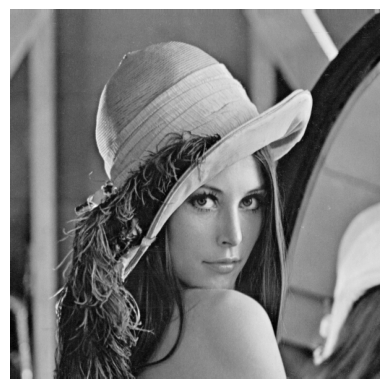

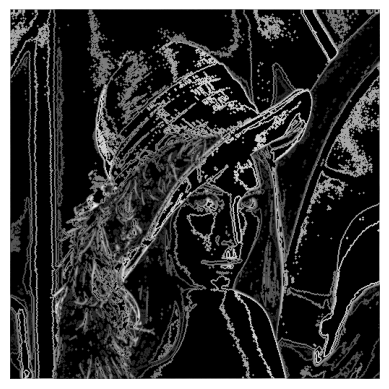

In [ ]:
visualizar_imagen_ByN(lena_ByN)
lena_bordes_ByN = bordes_segmentados_sigma(lena_ByN, 40)
visualizar_imagen_ByN(lena_bordes_ByN)

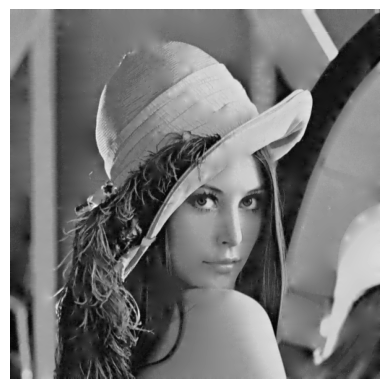

In [ ]:
# Verificar si CUDA está disponible
if not cuda.is_available():
    raise RuntimeError("CUDA no está disponible. Por favor, verifica la instalación de CUDA y los controladores de la GPU.")

@cuda.jit
def sor_solver_2_kernel(matriz, original, omega):
    n, m = matriz.shape
    i, j = cuda.grid(2)

    if 0 < i < n - 1 and 0 < j < m - 1:
        if original[i, j] == 0:
            u_x = (matriz[i + 1, j] - matriz[i - 1, j]) / 2.0
            u_y = (matriz[i, j + 1] - matriz[i, j - 1]) / 2.0
            u_x_y_4 = (u_x * u_y) / 4.0
            u_x2 = u_x ** 2
            u_y2 = u_y ** 2

            sigma = -u_x_y_4 * matriz[i - 1, j + 1] + u_y2 * matriz[i, j + 1] \
                    + u_x_y_4 * matriz[i + 1, j + 1] + u_x2 * matriz[i - 1, j] \
                    + u_x2 * matriz[i + 1, j] \
                    + u_x_y_4 * matriz[i - 1, j - 1] + u_y2 * matriz[i, j - 1] \
                    - u_x_y_4 * matriz[i + 1, j - 1]

            denominator = 2.0 * (u_x2 + u_y2)
            if denominator != 0:
                matriz[i, j] = (1 - omega) * matriz[i, j] + (omega / denominator) * sigma
            else:
                matriz[i, j] = (matriz[i + 1, j] + matriz[i, j - 1]) * 0.5

def solve_iterations_cuda(matriz, original, omega, iterations):

    n, m = matriz.shape
    threadsperblock = (16, 16)
    blockspergrid_x = (n + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (m + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    d_matriz = cuda.to_device(matriz.astype(np.float64))  # Copiar matriz al dispositivo
    d_original = cuda.to_device(original.astype(np.float64))  # Copiar matriz al dispositivo

    for _ in range(iterations):
        sor_solver_2_kernel[blockspergrid, threadsperblock](d_matriz, d_original, omega)
        cuda.synchronize()  # Asegurar que todos los bloques hayan terminado antes de la siguiente iteración

    d_matriz.copy_to_host(matriz)  # Copiar resultado de vuelta al host

    return np.clip(np.round(matriz), 0, 255)

# Supongo que lena_bordes_ByN es una imagen cargada previamente
u = lena_bordes_ByN.copy().astype(np.float64)
omega = 0.75
k = solve_iterations_cuda(u, lena_bordes_ByN, omega, 10000)
visualizar_imagen_ByN(k)  # Seleccionamos la última iteración


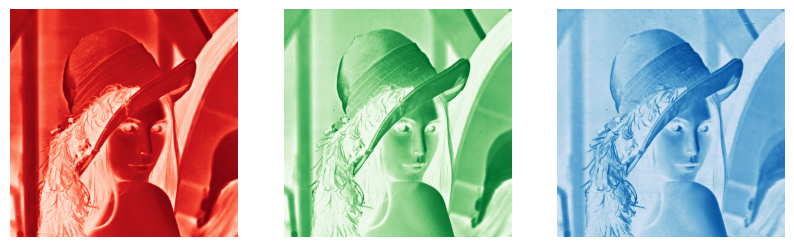

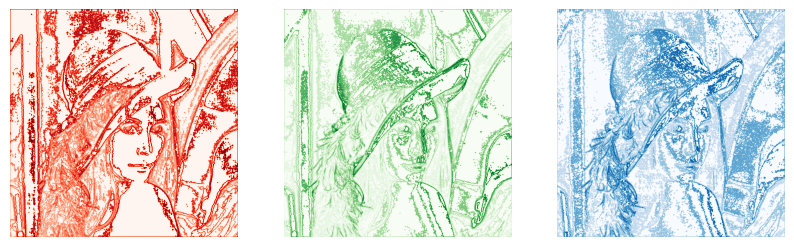

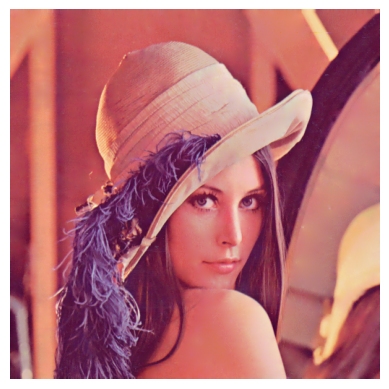

In [ ]:

# URL de la imagen a descargar
url_lena = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'

# Descargar la imagen en RGB
matriz_r, matriz_g, matriz_b = url_2_matriz_rgb(url_lena)

# Mostrar la imagen reconstruida en RGB
mostrar_matrices_rgb(matriz_r, matriz_g, matriz_b)

# Agrupar los píxeles según su rango de valores
matriz_r_bordes = bordes_segmentados_sigma(matriz_r, sigma = 30)
matriz_g_bordes = bordes_segmentados_sigma(matriz_g, sigma = 30)
matriz_b_bordes = bordes_segmentados_sigma(matriz_b, sigma = 30)

# Mostramos el estado inicial que utilizaremos
mostrar_matrices_rgb(matriz_r_bordes, matriz_g_bordes, matriz_b_bordes)

u_r = matriz_r_bordes.copy().astype(np.float64)
u_g = matriz_g_bordes.copy().astype(np.float64)
u_b = matriz_b_bordes.copy().astype(np.float64)

omega = 0.75

matriz_r_reconstruida = solve_iterations_cuda(u_r, matriz_r_bordes, omega, 10000)
matriz_g_reconstruida = solve_iterations_cuda(u_g, matriz_g_bordes, omega, 10000)
matriz_b_reconstruida = solve_iterations_cuda(u_b, matriz_b_bordes, omega, 10000)

#Mostramos el rsultado
mostrar_imagen_reconstruida(matriz_r_reconstruida, matriz_g_reconstruida, matriz_b_reconstruida)